### Importing dependencies

In [11]:
import os
from google.colab import drive

from tqdm import notebook as tqdm
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomHorizontalFlip

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Loading and Pre Processing Data

Resizing the images (so they each have the same amount of pixels, not to overfit to larger images) and converting them to Tensor, so they can be used in the model.

Import the data from Google Drive as we assume that this is running on Google Colab.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
means = [0.43766510486602783, 0.49804747104644775, 0.3756938874721527]
stds = [0.16779577732086182, 0.1552586406469345, 0.1632111817598343]
transform_train = Compose([RandomHorizontalFlip(), RandomVerticalFlip(), Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_val = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])
transform_test = Compose([Resize(size=(64,64)), ToTensor(),Normalize(mean=means, std=stds)])


train_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/train",transform=transform_train)
val_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/val",transform=transform_val)
test_dataset = ImageFolder(root="/content/drive/MyDrive/splitted_data/test",transform=transform_test)
diffBg_dataset = ImageFolder(root="/content/drive/MyDrive/diffBg",transform=transform_test)

### Use a GPU if available

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

## Defining the LeNet Model Architecture

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(2704, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 4)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

## Perform a sanity check for the correctness of the model

In [ ]:
net = LeNet()
net = net.to(device)
data = torch.randn(5,3,64,64)
data = data.to(device)
out = net.forward(data)
assert(out.detach().cpu().numpy().shape == (5,4))
print("Forward pass successful, shape matches")

for layer in net.children():
  print(layer)
  print(sum(p.numel() for p in layer.parameters()))

Forward pass successful, shape matches
Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
456
ReLU()
0
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
0
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
2416
ReLU()
0
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
0
Linear(in_features=2704, out_features=120, bias=True)
324600
ReLU()
0
Linear(in_features=120, out_features=84, bias=True)
10164
ReLU()
0
Linear(in_features=84, out_features=4, bias=True)
340
ReLU()
0


### Move data and the model to the GPU

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=16)
diffBg_dl = DataLoader(diffBg_dataset, batch_size=16)

!nvidia-smi

Sat Apr 20 19:31:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0              27W /  70W |    163MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining a Loss Function and Optimizer

In [ ]:
# hyperparameters
INITIAL_LR = 0.005 # initial learning rate
MOMENTUM = 0.9 # momentum for optimizer

REG = 1e-3 # L2 regularization strength

criterion = nn.CrossEntropyLoss() # loss function

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay = REG)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

best_val_acc = 0
current_learning_rate = INITIAL_LR

DECAY_EPOCHS = 10
DECAY = 1

## Train the model

In [12]:
print("Training:")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(0, EPOCHS):
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    net.train() # switch to train mode

    print("Epoch %d:" %i)
    total_examples = 0
    correct_examples = 0

    train_loss = 0

    # 1 epoch training
    for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(train_dl), "training..."):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = net.forward(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        # count the number of correctly predicted samples in the current batch

        _, predicted = torch.max(outputs, 1)
        correct = predicted.eq(targets).sum()

        correct_examples += correct
        total_examples += len(targets)
        train_loss += loss

    avg_loss = train_loss / len(train_dl)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    history['train_loss'].append(avg_loss)
    history['train_acc'].append(avg_acc)

    net.eval()

    total_examples = 0
    correct_examples = 0

    val_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm.tqdm(enumerate(val_dl), "validating..."):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)

            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()

            correct_examples += correct
            total_examples += len(targets)
            val_loss += loss

    avg_loss = val_loss / len(val_dl)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    history['val_loss'].append(avg_loss)
    history['val_acc'].append(avg_acc)

    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
           os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'LeNet.pth'))

    print('')

print("="*50)
print(f"Optimization finished: best validation accuracy is {best_val_acc:.4f}")

Training:
Epoch 0:


training...: 0it [00:00, ?it/s]

Training loss: 1.1965, Training accuracy: 0.3844


validating...: 0it [00:00, ?it/s]

Validation loss: 1.0668, Validation accuracy: 0.5012
Saving ...

Epoch 1:


training...: 0it [00:00, ?it/s]

Training loss: 1.0222, Training accuracy: 0.5139


validating...: 0it [00:00, ?it/s]

Validation loss: 1.0226, Validation accuracy: 0.5156
Saving ...

Epoch 2:


training...: 0it [00:00, ?it/s]

Training loss: 1.0031, Training accuracy: 0.5245


validating...: 0it [00:00, ?it/s]

Validation loss: 1.0065, Validation accuracy: 0.5275
Saving ...

Epoch 3:


training...: 0it [00:00, ?it/s]

Training loss: 0.9767, Training accuracy: 0.5367


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9914, Validation accuracy: 0.5275

Epoch 4:


training...: 0it [00:00, ?it/s]

Training loss: 0.9490, Training accuracy: 0.5439


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9753, Validation accuracy: 0.5383
Saving ...

Epoch 5:


training...: 0it [00:00, ?it/s]

Training loss: 0.9291, Training accuracy: 0.5483


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9710, Validation accuracy: 0.5383

Epoch 6:


training...: 0it [00:00, ?it/s]

Training loss: 0.9184, Training accuracy: 0.5490


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9548, Validation accuracy: 0.5419
Saving ...

Epoch 7:


training...: 0it [00:00, ?it/s]

Training loss: 0.9101, Training accuracy: 0.5503


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9533, Validation accuracy: 0.5347

Epoch 8:


training...: 0it [00:00, ?it/s]

Training loss: 0.9067, Training accuracy: 0.5527


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9427, Validation accuracy: 0.5407

Epoch 9:


training...: 0it [00:00, ?it/s]

Training loss: 0.8925, Training accuracy: 0.5568


validating...: 0it [00:00, ?it/s]

Validation loss: 0.9327, Validation accuracy: 0.5478
Saving ...

Current learning rate has decayed to 0.005000
Epoch 10:


training...: 0it [00:00, ?it/s]

Training loss: 0.8893, Training accuracy: 0.6136


validating...: 0it [00:00, ?it/s]

Validation loss: 0.8801, Validation accuracy: 0.7213
Saving ...

Epoch 11:


training...: 0it [00:00, ?it/s]

Training loss: 0.7519, Training accuracy: 0.7796


validating...: 0it [00:00, ?it/s]

Validation loss: 0.6628, Validation accuracy: 0.7799
Saving ...

Epoch 12:


training...: 0it [00:00, ?it/s]

Training loss: 0.4914, Training accuracy: 0.8044


validating...: 0it [00:00, ?it/s]

Validation loss: 0.5082, Validation accuracy: 0.8002
Saving ...

Epoch 13:


training...: 0it [00:00, ?it/s]

Training loss: 0.4333, Training accuracy: 0.8167


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4402, Validation accuracy: 0.8170
Saving ...

Epoch 14:


training...: 0it [00:00, ?it/s]

Training loss: 0.4010, Training accuracy: 0.8320


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4548, Validation accuracy: 0.8098

Epoch 15:


training...: 0it [00:00, ?it/s]

Training loss: 0.3846, Training accuracy: 0.8340


validating...: 0it [00:00, ?it/s]

Validation loss: 0.4071, Validation accuracy: 0.8385
Saving ...

Epoch 16:


training...: 0it [00:00, ?it/s]

Training loss: 0.3575, Training accuracy: 0.8442


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3889, Validation accuracy: 0.8409
Saving ...

Epoch 17:


training...: 0it [00:00, ?it/s]

Training loss: 0.3499, Training accuracy: 0.8548


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3901, Validation accuracy: 0.8301

Epoch 18:


training...: 0it [00:00, ?it/s]

Training loss: 0.3348, Training accuracy: 0.8629


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3796, Validation accuracy: 0.8481
Saving ...

Epoch 19:


training...: 0it [00:00, ?it/s]

Training loss: 0.3233, Training accuracy: 0.8653


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3890, Validation accuracy: 0.8397

Current learning rate has decayed to 0.005000
Epoch 20:


training...: 0it [00:00, ?it/s]

Training loss: 0.3216, Training accuracy: 0.8650


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3550, Validation accuracy: 0.8577
Saving ...

Epoch 21:


training...: 0it [00:00, ?it/s]

Training loss: 0.3130, Training accuracy: 0.8660


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3925, Validation accuracy: 0.8421

Epoch 22:


training...: 0it [00:00, ?it/s]

Training loss: 0.3108, Training accuracy: 0.8796


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3879, Validation accuracy: 0.8493

Epoch 23:


training...: 0it [00:00, ?it/s]

Training loss: 0.3108, Training accuracy: 0.8755


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3516, Validation accuracy: 0.8565

Epoch 24:


training...: 0it [00:00, ?it/s]

Training loss: 0.2951, Training accuracy: 0.8769


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3325, Validation accuracy: 0.8565

Epoch 25:


training...: 0it [00:00, ?it/s]

Training loss: 0.2823, Training accuracy: 0.8854


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3177, Validation accuracy: 0.8636
Saving ...

Epoch 26:


training...: 0it [00:00, ?it/s]

Training loss: 0.2773, Training accuracy: 0.8820


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3278, Validation accuracy: 0.8672
Saving ...

Epoch 27:


training...: 0it [00:00, ?it/s]

Training loss: 0.2768, Training accuracy: 0.8854


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3616, Validation accuracy: 0.8409

Epoch 28:


training...: 0it [00:00, ?it/s]

Training loss: 0.2770, Training accuracy: 0.8813


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3189, Validation accuracy: 0.8756
Saving ...

Epoch 29:


training...: 0it [00:00, ?it/s]

Training loss: 0.2645, Training accuracy: 0.8922


validating...: 0it [00:00, ?it/s]

Validation loss: 0.3466, Validation accuracy: 0.8541

Optimization finished: best validation accuracy is 0.8756


### Show the plots of the training and validation losses

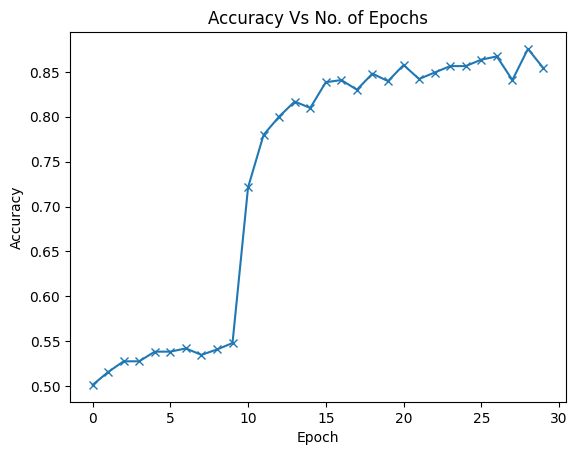

In [13]:
def plot_accuracies(history):
  accuracies = [x.cpu().item() for x in history['val_acc']]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title("Accuracy Vs No. of Epochs")

plot_accuracies(history)

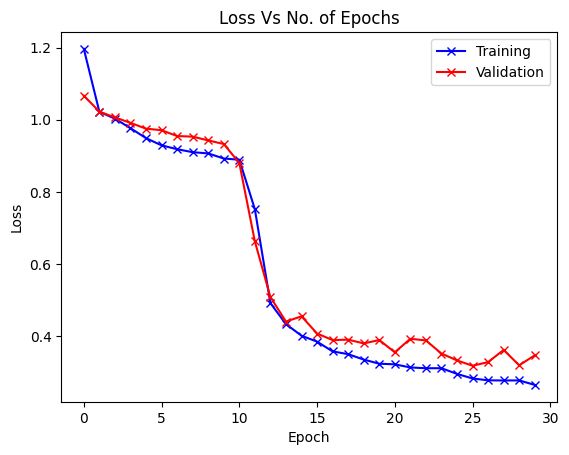

In [14]:
def plot_losses(history):
  train_losses = [x.cpu().item() for x in history['train_loss']]
  val_losses = [x.cpu().item() for x in history['val_loss']]
  plt.plot(train_losses,'-bx')
  plt.plot(val_losses,'-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training','Validation'])
  plt.title("Loss Vs No. of Epochs")
plot_losses(history)

### Evaluate the model with the test set

evaluating...:   0%|          | 0/27 [00:00<?, ?it/s]

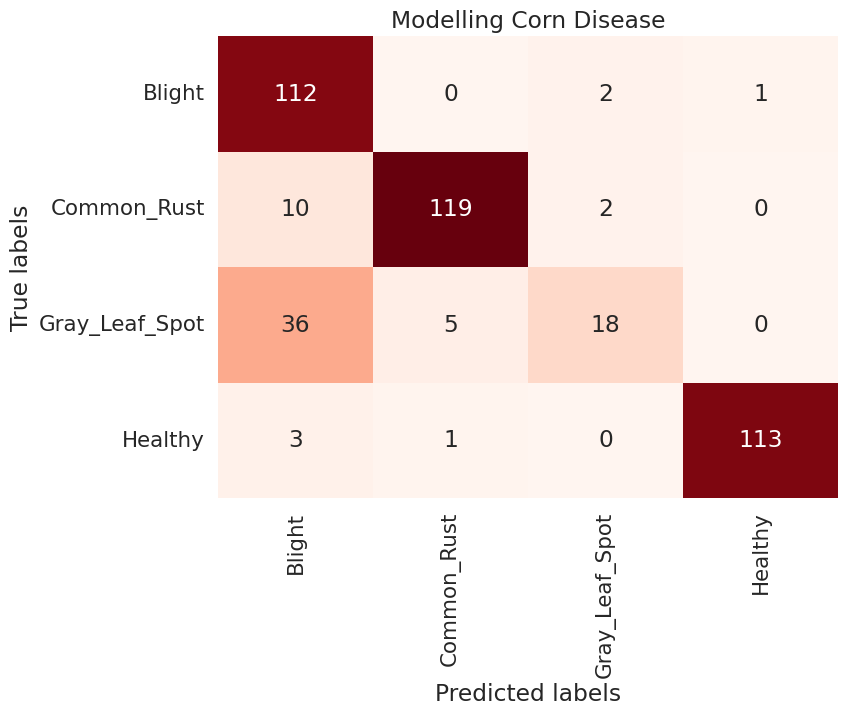

In [15]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(test_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Modelling Corn Disease')
plt.show()

## Additional testing on images with different backgrounds

evaluating...:   0%|          | 0/17 [00:00<?, ?it/s]

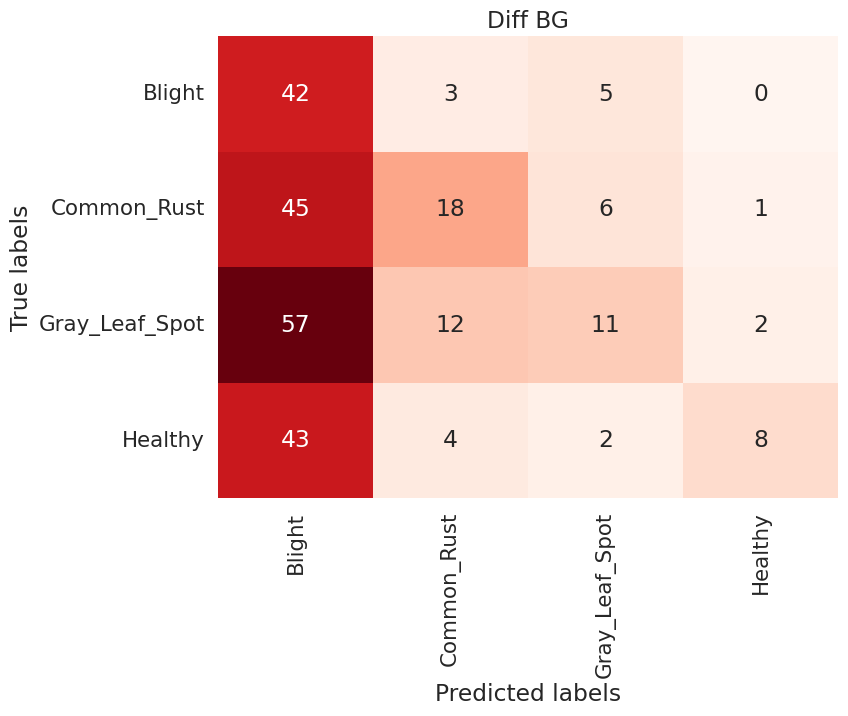

In [16]:
net.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in tqdm.tqdm(diffBg_dl, "evaluating..."):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(true_labels,predicted_labels)
class_names = train_dataset.classes

plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Reds", cbar=False, xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Diff BG')
plt.show()